In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# %cd /content/drive/MyDrive/Term 8/Term 8 Artificial Intelligence/folder
# %cd /content/drive/MyDrive/CellCount

In [6]:
!git clone https://github.com/Bjarten/early-stopping-pytorch.git ./earlystopping

fatal: destination path './earlystopping' already exists and is not an empty directory.


In [2]:
import os
import torch
import datetime
from model import *
from utils import *
import numpy as np
from tqdm import tqdm
from PIL import Image
from skimage import io
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from scipy.io import loadmat, savemat
from torch.utils.data import Dataset, DataLoader
from earlystopping.pytorchtools import EarlyStopping
from torch.utils.data.sampler import SubsetRandomSampler

# Dataset and Dataloader

In [3]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

class CellDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        self.fileNames = [i[:-4] for i in sorted(os.listdir(root_dir+"/Labels/"))]
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.fileNames)
    
    """
    returns: tuple of
    - image
    - mask of size n x n with unique values/classes ranging from 0 to 4 
        0: background
        1: others (1)
        2: inflammatory(2)
        3: healthy epithelial(3) , dysplastic/malignant epithelial(4)
        4: fibroblast(5) , muscle(6) , endothelial(7)
    """
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,"Images",self.fileNames[idx])+".png"
        image = img = Image.open(img_name).convert('RGB')
        mask_name = os.path.join(self.root_dir,"Labels",self.fileNames[idx])+".mat"
        x = loadmat(mask_name)['type_map']
        x[(x==3)|(x==4)]=3
        x[(x==5)|(x==6)|(x==7)]=4
        x=np.pad(x.astype(int),6)
        if self.transform:
            image = self.transform(image)
        return image, to_categorical(x,5).transpose(2, 0, 1) #(num_classes=5, n, n)

In [4]:
transform = transforms.Compose([
    transforms.Pad(6),
    transforms.ToTensor()    
])

valid_size = 0.2
batch_size =1

# DataLoader
train_data = CellDataset(root_dir="./Train/train_500", transform = transform)
test_data = CellDataset(root_dir="./Test/test_500", transform = transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# load training data in batches
train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          sampler=train_sampler,
                          num_workers=0)

# load validation data in batches
valid_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          sampler=valid_sampler,
                          num_workers=0)

# load test data in batches
test_loader = DataLoader(test_data,
                        batch_size=batch_size,
                        num_workers=0)

## Training

In [6]:
def weighted_loss(pred,targ,bce_weight=0.7, smooth=1.):
    
    bce = F.binary_cross_entropy_with_logits(pred.squeeze(dim=1), targ)
    
    pred = torch.sigmoid(pred)
    
    pred = pred.contiguous().squeeze(dim=1)  
    targ = targ.contiguous()  

    intersection = (pred * targ).sum(dim=1).sum(dim=1)
    dice = (1 - ((2. * intersection + smooth) / (pred.sum(dim=1).sum(dim=1) + targ.sum(dim=1).sum(dim=1) + smooth)))
    
    loss = bce * bce_weight + dice.mean() * (1 - bce_weight)
    
    return loss

def train(model, device, train_loader, valid_loader, optimizer, epochs, patience, model_chkpt_name):
    train_losses = []
    valid_losses = []
    avg_train_losses = [] # average training loss per epoch
    avg_valid_losses = [] # average validation loss per epoch
    valid_acc = 0
    
    os.makedirs("best_model_checkpoints", exist_ok=True)
    os.makedirs("model_checkpoints", exist_ok=True)
    save_path = f"best_model_checkpoints/{model.__class__.__name__}.pth"
    early_stopping = EarlyStopping(patience=patience, path=save_path, verbose=True)
    for epoch in tqdm(range(1, epochs + 1)):
        train_loss = 0
        valid_loss = 0
        score = 0
        """
        Trains the model on training data
        """
        for batch_idx, (data, target) in enumerate(train_loader):
            model.train()
            data, target = data.to(device), target.to(device).float()

            optimizer.zero_grad()
            output = model(data)
            loss = weighted_loss(output,target,bce_weight=0.5) 
            loss.backward()
            optimizer.step()

            train_loss+=(loss/len(data)).item()
            train_losses.append(loss.item())
            # Find accuracy
        
        """
        Validate the model on validation data
        """
        model.eval()
        for batch_idx, (data, target) in enumerate(valid_loader):
            data, target = data.to(device), target.to(device).float()
            output = model(data)
            loss = weighted_loss(output,target,bce_weight=0.3)
            valid_loss+=(loss/len(data)).item()
            valid_losses.append(loss.item())
            pred = output[0].to('cpu').detach()
            pred=F.softmax(pred, dim=0)# along the channel
            pred=pred.numpy()
            pred[pred.max(axis=0,keepdims=1) == pred] = 1
            pred[pred.max(axis=0,keepdims=1) != pred] = 0
            score+=get_dice_1(target, pred)

        train_loss /= len(train_loader)
        valid_loss /= len(valid_loader)
        score /= len(valid_loader)
        if score > valid_acc:
            valid_acc = score

        # average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        # clear lists to track next epoch
        train_losses = []
        valid_losses = []

        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

        torch.save(model.state_dict(), f"model_checkpoints/{model.__class__.__name__}_{model_chkpt_name}_{epoch}.pth")
        print('Train Epoch: {} @ {} - Train Loss: {:.4f} - Valid Loss: {:.4f}'.format(epoch, datetime.datetime.now().time(), train_loss, valid_loss))

    # load the last checkpoint with the best model
    model.load_state_dict(torch.load(save_path)) 

    return  model, avg_train_losses, avg_valid_losses, valid_acc

In [8]:
# Set cpu / gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model and optimizer
model = build_model(device, "resnet")
model.to(device)

lr = 0.001
optimizer = Adam(model.parameters(), lr=lr)

In [6]:
# Training the model
print("Training")

epochs = 100
patience = 10  # how long to wait after last time validation loss improved
model_chkpt_name = "ResNet-500x500"

model, train_loss, valid_loss, valid_acc = train(model, device, train_loader, valid_loader, optimizer, epochs, patience, model_chkpt_name)

  0%|          | 0/100 [00:00<?, ?it/s]

Training
Validation loss decreased (inf --> 0.118768).  Saving model ...


  1%|          | 1/100 [00:22<36:19, 22.02s/it]

Train Epoch: 1 @ 09:41:33.840128 - Train Loss: 0.2196 - Valid Loss: 0.1188
EarlyStopping counter: 1 out of 10


  2%|▏         | 2/100 [00:43<35:41, 21.85s/it]

Train Epoch: 2 @ 09:41:55.303631 - Train Loss: 0.1615 - Valid Loss: 0.2089
Validation loss decreased (0.118768 --> 0.106937).  Saving model ...


  3%|▎         | 3/100 [01:05<35:12, 21.78s/it]

Train Epoch: 3 @ 09:42:16.921137 - Train Loss: 0.1464 - Valid Loss: 0.1069
Validation loss decreased (0.106937 --> 0.093654).  Saving model ...


  4%|▍         | 4/100 [01:26<34:52, 21.80s/it]

Train Epoch: 4 @ 09:42:38.769319 - Train Loss: 0.1387 - Valid Loss: 0.0937
Validation loss decreased (0.093654 --> 0.090398).  Saving model ...


  5%|▌         | 5/100 [01:48<34:35, 21.85s/it]

Train Epoch: 5 @ 09:43:00.730824 - Train Loss: 0.1231 - Valid Loss: 0.0904
EarlyStopping counter: 1 out of 10


  6%|▌         | 6/100 [02:10<33:59, 21.69s/it]

Train Epoch: 6 @ 09:43:22.057064 - Train Loss: 0.1196 - Valid Loss: 0.1680
Validation loss decreased (0.090398 --> 0.082560).  Saving model ...


  7%|▋         | 7/100 [02:31<33:28, 21.60s/it]

Train Epoch: 7 @ 09:43:43.439997 - Train Loss: 0.1245 - Valid Loss: 0.0826
Validation loss decreased (0.082560 --> 0.080655).  Saving model ...


  8%|▊         | 8/100 [02:53<33:11, 21.64s/it]

Train Epoch: 8 @ 09:44:05.190902 - Train Loss: 0.1094 - Valid Loss: 0.0807
EarlyStopping counter: 1 out of 10


  9%|▉         | 9/100 [03:14<32:38, 21.52s/it]

Train Epoch: 9 @ 09:44:26.429101 - Train Loss: 0.1017 - Valid Loss: 0.0854
EarlyStopping counter: 2 out of 10


 10%|█         | 10/100 [03:35<32:06, 21.41s/it]

Train Epoch: 10 @ 09:44:47.561785 - Train Loss: 0.1311 - Valid Loss: 0.0912
EarlyStopping counter: 3 out of 10


 11%|█         | 11/100 [03:56<31:41, 21.36s/it]

Train Epoch: 11 @ 09:45:08.819825 - Train Loss: 0.1066 - Valid Loss: 0.0864
EarlyStopping counter: 4 out of 10


 12%|█▏        | 12/100 [04:18<31:18, 21.34s/it]

Train Epoch: 12 @ 09:45:30.116021 - Train Loss: 0.0948 - Valid Loss: 0.0899
EarlyStopping counter: 5 out of 10


 13%|█▎        | 13/100 [04:39<31:00, 21.38s/it]

Train Epoch: 13 @ 09:45:51.599131 - Train Loss: 0.0939 - Valid Loss: 0.0893
Validation loss decreased (0.080655 --> 0.077225).  Saving model ...


 14%|█▍        | 14/100 [05:01<30:43, 21.43s/it]

Train Epoch: 14 @ 09:46:13.151649 - Train Loss: 0.0881 - Valid Loss: 0.0772
EarlyStopping counter: 1 out of 10


 15%|█▌        | 15/100 [05:22<30:20, 21.42s/it]

Train Epoch: 15 @ 09:46:34.521498 - Train Loss: 0.0896 - Valid Loss: 0.1002
EarlyStopping counter: 2 out of 10


 16%|█▌        | 16/100 [05:43<29:54, 21.36s/it]

Train Epoch: 16 @ 09:46:55.750758 - Train Loss: 0.0837 - Valid Loss: 0.0795
Validation loss decreased (0.077225 --> 0.075603).  Saving model ...


 17%|█▋        | 17/100 [06:05<29:33, 21.37s/it]

Train Epoch: 17 @ 09:47:17.156479 - Train Loss: 0.0829 - Valid Loss: 0.0756
Validation loss decreased (0.075603 --> 0.073766).  Saving model ...


 18%|█▊        | 18/100 [06:26<29:12, 21.37s/it]

Train Epoch: 18 @ 09:47:38.526401 - Train Loss: 0.0822 - Valid Loss: 0.0738
EarlyStopping counter: 1 out of 10


 19%|█▉        | 19/100 [06:48<28:52, 21.39s/it]

Train Epoch: 19 @ 09:47:59.960669 - Train Loss: 0.0832 - Valid Loss: 0.0843
EarlyStopping counter: 2 out of 10


 20%|██        | 20/100 [07:09<28:28, 21.35s/it]

Train Epoch: 20 @ 09:48:21.215520 - Train Loss: 0.0783 - Valid Loss: 0.0755
EarlyStopping counter: 3 out of 10


 21%|██        | 21/100 [07:30<28:03, 21.31s/it]

Train Epoch: 21 @ 09:48:42.417200 - Train Loss: 0.0738 - Valid Loss: 0.0819
EarlyStopping counter: 4 out of 10


 22%|██▏       | 22/100 [07:51<27:42, 21.31s/it]

Train Epoch: 22 @ 09:49:03.739320 - Train Loss: 0.0735 - Valid Loss: 0.0824
EarlyStopping counter: 5 out of 10


 23%|██▎       | 23/100 [08:12<27:14, 21.23s/it]

Train Epoch: 23 @ 09:49:24.769280 - Train Loss: 0.0852 - Valid Loss: 0.0842
EarlyStopping counter: 6 out of 10


 24%|██▍       | 24/100 [08:34<26:53, 21.23s/it]

Train Epoch: 24 @ 09:49:46.008466 - Train Loss: 0.0805 - Valid Loss: 0.0841
EarlyStopping counter: 7 out of 10


 25%|██▌       | 25/100 [08:55<26:34, 21.26s/it]

Train Epoch: 25 @ 09:50:07.324353 - Train Loss: 0.0725 - Valid Loss: 0.0755
EarlyStopping counter: 8 out of 10


 26%|██▌       | 26/100 [09:16<26:13, 21.26s/it]

Train Epoch: 26 @ 09:50:28.607389 - Train Loss: 0.0708 - Valid Loss: 0.0755
EarlyStopping counter: 9 out of 10


 27%|██▋       | 27/100 [09:37<25:50, 21.24s/it]

Train Epoch: 27 @ 09:50:49.787331 - Train Loss: 0.0691 - Valid Loss: 0.0742


 27%|██▋       | 27/100 [09:58<26:59, 22.18s/it]

EarlyStopping counter: 10 out of 10
Early stopping


In [7]:
print("DICE score:", valid_acc)

DICE score: 0.9381444012677228


# Load model


In [9]:
# load saved model
def load_model(model):
  path = f"best_model_checkpoints/{model.__class__.__name__}.pth"
  model.load_state_dict(torch.load(path)) 
  model.eval()
  return model
model = load_model(model)

# Test

In [10]:
"""
0: black: background
1: red: others (1)
2: green: inflammatory(2)
3: dark blue: healthy epithelial(3) , dysplastic/malignant epithelial(4)
4: light blue: fibroblast(5) , muscle(6) , endothelial(7)
"""
# params: 5 x n x n numpy or n x n x 5
def printColoredMask(npMask,numchannel=5):
    if npMask.shape[-1]!=5:
        npMask=npMask.transpose(1, 2, 0)
    finalnpMask=np.where(npMask[:,:,1]==1,255,0) # one color
    finalnpMask=finalnpMask[:,:,None]
    temp=np.where((npMask[:,:,2]==1)|(npMask[:,:,4]==1),255,0) # one color
    finalnpMask = np.concatenate((finalnpMask,temp[:, :, None]),axis=2)
    temp=np.where((npMask[:,:,3]==1)|(npMask[:,:,4]==1),255,0) # one color
    finalnpMask = np.concatenate((finalnpMask,temp[:, :, None]),axis=2)
    plt.imshow(finalnpMask)
    plt.show()

In [11]:
def test(model, device, data, target):
    print("Input Image")
    plt.imshow(data[0].numpy().transpose(1, 2, 0))
    plt.show()
    outputs = model(data.to(device))[0]
    pred = outputs.to('cpu').detach()
    pred=F.softmax(pred, dim=0)# along the channel
    pred=pred.numpy()

    print("Predicted Mask Sigmoid")
    pred[pred.max(axis=0,keepdims=1) == pred] = 1
    pred[pred.max(axis=0,keepdims=1) != pred] = 0
    printColoredMask(pred)
    print("Actual Mask")
    printColoredMask(target[0].numpy())

    # PQ
    pq_score = get_fast_pq(target, pred)[0]
    print("Detection Quality (DQ):", pq_score[0])
    print("Segmentation Quality (SQ):", pq_score[1])
    print("Panoptic Quality (PQ):", pq_score[2])
    
    dice_score = get_dice_1(target, pred)
    print("Dice score:", dice_score, "\n")

Input Image


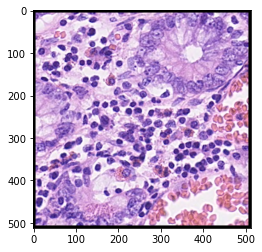

Predicted Mask Sigmoid


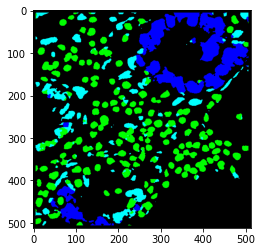

Actual Mask


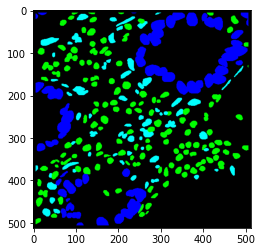

Detection Quality (DQ): 1.0
Segmentation Quality (SQ): 0.7608853784101839
Panoptic Quality (PQ): 0.7608853784101839
Dice score: 0.8642082214355469 



In [12]:
# Testing the model
for data, target in test_loader:
    test(model, device, data, target)
    break